In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score


from PIL import Image

%matplotlib inline

# Together

DBSCAN is a non-parametric clustering algorithm, meaning it does not make any assumptions about the shape of the clusters. This is great news for clusters that look like this:

<img src = "https://drive.google.com/uc?export=view&id=1oEgxzeR3ryvs-jp3OHv1jty6EgOs1wlz" alt="Q" style="width: 500px;"/>

It also introduces the concept of "Noise": data points that don't really fit into *any* cluster, like the smattering of points in database 3.

## Algo Review
In general, the algorithm is iterative, starting with a random core point, and finding all the **density connected/reachable** points from that **core point** and putting them into a cluster. Then it moves on to the next point.

<img src = "https://drive.google.com/uc?export=view&id=1XhHBpFnzgX2gx3vGT7LLNLCVXKbgqqY5" alt="Q" style="width: 300px;"/>

If a data point is **noise**, it marks it as such and moves on. This process repeats until all data points have been categorized.


<img src = "https://drive.google.com/uc?export=view&id=10ciqJpBrcnH7-Qdg2qokOHAIPbyub0p0" alt="Q" style="width: 500px;"/>


# PIL in Python

To get the PIL library in python, run `pip install pillow` in terminal/command prompt.

If you have a MAC you may need to say `pip3 install pillow`.

If you get an error about not having permission, you may need to run `sudo pip install pillow` or `sudo pip3 install pillow` (MAC) and then enter your password.

If none of this works, feel free to use [Google Colab](https://colab.research.google.com/) for this classwork.

## Loading in an image using the PIL package

In [2]:
# open the image
mount = Image.open('/Users/cparlett/Desktop/Desktop/School/CPSC392ParlettPelleriti/Data/Images/MountainLandscape.jpg','r')

# grab the image size
width, height = mount.size

# turn the image into a data frame of all the pixels
# with RBG columns
pixels = list(mount.getdata())

R = [i[0] for i in pixels]
G = [i[1] for i in pixels]
B = [i[2] for i in pixels]

mount_df = pd.DataFrame({"R": R,
                        "G": G,
                        "B": B})

print("The width/height of this image is: ", width, " by ", height, " pixels")

mount_df.head()

The width/height of this image is:  500  by  333  pixels


,R,G,B
0,187,210,218
1,188,211,219
2,188,211,219
3,188,211,219
4,188,211,219


In [3]:
# show the image
mount.show()

# Color Quantization

This image of a mountain landscape is rich and beautiful. But say we're trying to save memory, or simplify the picture, and use fewer distinct colors. 

Color Quantization "is a process that reduces the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image."

In other words, we're trying to reduce the # of colors used, while still preserving the general form of the image.

## Simple K-Means Clustering of Pixels
Now that you can see the beautiful mountain image, let's use *clustering* to cluster the pixels from this image according to their color. The Red, Green and Blue values (R, G, and B) are all on the same scale (0-255), so there is no need to z score.

The R, G, and B are the features we are going to cluster on. You can think of color in terms of the amount (0-255) of Red, Green, and Blue, and envision a 3D plot of all possible colors.

<img src = "https://drive.google.com/uc?export=view&id=13AS1p5D2SMhD8LLiUTNZDzEKPQMyPU92" alt="Q" style="width: 500px;"/>


We want to cluster similar colors together so that our image is simpler, but still close to the original. First, let's try with a super simple K-Means Cluster.

The dataframe `mount_df` contains all the pixel colors from our mountain image. 

1. Create a k-means model with k = 10, and store it in the variable `km`
2. Fit the k-means model on the `mount_df` dataframe
3. Run the following cells to see the new image with clustered colors

In [4]:
### YOUR CODE HERE ################################

# 1. create a K-Means Model
km = KMeans(10)

# 2. fit K-Means Model to Pixel Data Frame, mount_df
km.fit(mount_df)

### /YOUR CODE HERE ###############################

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Run these Cells after Running K-Means to see how the image colors were simplified

In [5]:
# grab the cluster assignment for each data point
cluster = km.labels_

# grab the cluster centers, these will be the colors we use
centers = km.cluster_centers_
centers = np.round(centers) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers = [tuple(map(int, c)) for c in centers] 

In [6]:
# record which cluster each pixel is in
mount_df["cluster"] = cluster

# grab the cluster center (the NEW color) for that pixel
mount_df["color_tuple"] = [centers[i] for i in mount_df["cluster"]]

In [7]:
# Turn these new colors into an image so you can plot it
mount_new_list = list(mount_df["color_tuple"])
mount_new = Image.new(mount.mode,mount.size)
mount_new.putdata(mount_new_list)

# show the NEW simpler image
mount_new.show()

# show the original image
mount.show()

### Question
- Compare the Original and Simpler/New image. What do you notice about how K-Means clustered those colors?


- If you change k to be something larger, like 25, what changes about the image?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

## DBSCAN Clustering of Pixels

Now, let's compare the K-Means clustering of the colors in that image with the DBSCAN clusters. Remember, DBSCAN doesn't require us to specify the number of clusters in advance.

1. Create a DBSCAN model using the `min_samples` and `eps` and store it in the variable `db`
2. Fit the DBSCAB model on the `mount_df` dataframe (this may take a few minutes to run)
3. Run the following cells to see the new image with clustered colors

In [8]:
### YOUR CODE HERE ################################
mins = 10
eps = 2
# build your DBSCAN model with min_samples = mins, and eps = whatever you found
db = DBSCAN(eps = eps, min_samples = mins)

# fit your model with mount_df's RGB columns
db.fit(mount_df[["R", "G", "B"]])

### /YOUR CODE HERE ###############################


DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

 ### Run these Cells after Running DBSCAN to see how the image colors were simplified


In [9]:
# grab the cluster assignment for each data point
cluster_db = db.labels_

# grab the mean color for each cluster
centers_db = [list(mount_df.loc[cluster_db == c,["R","G","B"]].mean()) for c in set(db.labels_)]
centers_db = np.round(centers_db) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers_db = [tuple(map(int, c)) for c in centers_db] 

In [10]:
# record which cluster each pixel is in
mount_df["cluster_db"] = cluster_db

# grab the cluster center (the NEW color) for that pixel
mount_df["color_tuple_db"] = [centers_db[i] for i in mount_df["cluster_db"]]

In [11]:
# Turn these new colors into an image so you can plot it
mount_new_list = list(mount_df["color_tuple_db"])
mount_new = Image.new(mount.mode,mount.size)
mount_new.putdata(mount_new_list)

# show the NEW simpler image
mount_new.show()

# show the original image
mount.show()

## Reflection

- Use ggplot to make a scatterplot of the `R` and `G` columns of `mount_df` (set alpha to 0.01).

- Use ggplot to make another scatterplot of the `R` and `B` columns of `mount_df` (set alpha to 0.01).

- Use ggplot to make a scatterplot of the `B` and `G` columns of `mount_df` (set alpha to 0.01).

(We make 3 graphs since we can't plot in 3D here).

### Question
- Look at the shapes, spread, and patterns in the data. Why do you see that's interesting? What do the patterns tell you about why DBSCAN performed the way it did (remember the benefits/disadvantages of DBSCAN we discussed in the lecture)?

- Think about what the parameter `eps` is. Given the large number of data points and how they're spread out, what do you think would happen if `eps` were larger? (you can try this out in your code)? Why?

- Also, we treated the "Noise" cluster (if it exists) as it's own cluster. Do you think this is a good idea? What else could we do with the noise cluster?



<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>


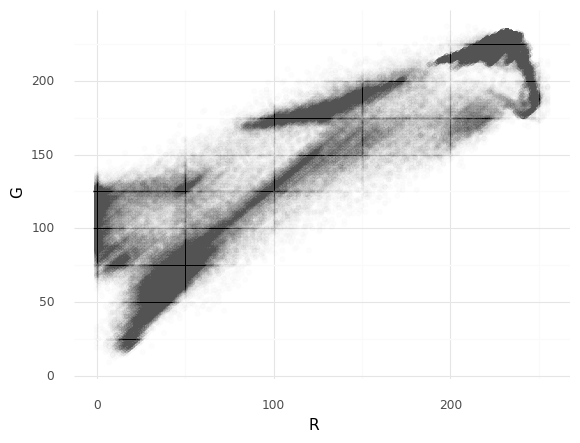

<ggplot: (8765172813490)>

In [12]:
(ggplot(mount_df, aes(x = "R", y = "G")) + geom_point(alpha = 0.01) +
theme_minimal())

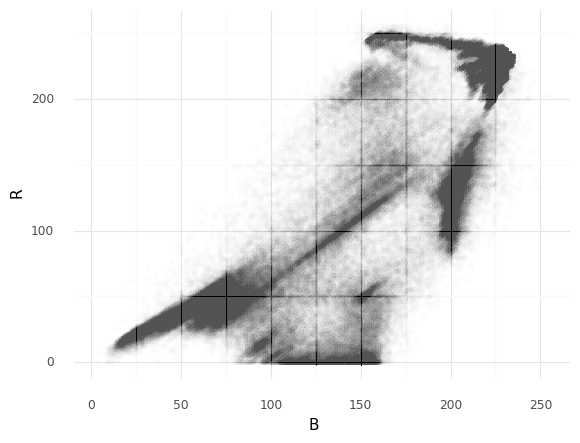

<ggplot: (8765124159133)>

In [13]:
(ggplot(mount_df, aes(x = "B", y = "R")) + geom_point(alpha = 0.01) +
theme_minimal())

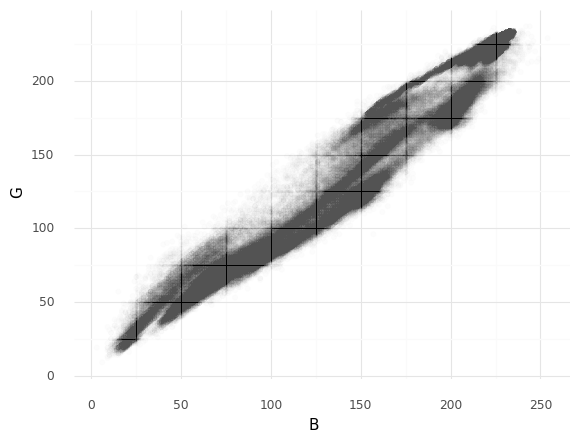

<ggplot: (8765118381376)>

In [14]:
(ggplot(mount_df, aes(x = "B", y = "G")) + geom_point(alpha = 0.01) +
theme_minimal())

## DBSCAN Clustering of Pixels (NOW WITH MORE CONTRAST)

The last image had a wide range of colors that sort of blended together. Let's see how DBSCAN does with an image with higher contrast.

1. Using a `min_samples` value of 5, build a k-dist graph like we did in the lecture to choose the best value for `eps`
2. Create a DBSCAN model using the `min_samples` and `eps` valuse from above, and store it in the variable `db`
3. Fit the DBSCAB model on the `john_df` dataframe (this may take a few minutes to run)
4. Run the following cells to see the new image with clustered colors

In [15]:
# open the image
john = Image.open('/Users/cparlett/Desktop/Desktop/School/CPSC392ParlettPelleriti/Data/Images/chrome.jpg','r')

# grab the image size
width, height = john.size

# turn the image into a data frame of all the pixels
# with RBG columns
pixels = list(john.getdata())

R = [i[0] for i in pixels]
G = [i[1] for i in pixels]
B = [i[2] for i in pixels]

john_df = pd.DataFrame({"R": R,
                        "G": G,
                        "B": B})

print("The width/height of this image is: ", width, " by ", height, " pixels")

john_df.head()

The width/height of this image is:  359  by  337  pixels


,R,G,B
0,200,200,200
1,200,200,200
2,200,200,200
3,200,200,200
4,200,200,200


In [16]:
john.show()

In [17]:
mins = 5
nn = NearestNeighbors(mins + 1)

nn.fit(john_df[["R", "G", "B"]])

distances, neighbors = nn.kneighbors(john_df[["R", "G", "B"]])

# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

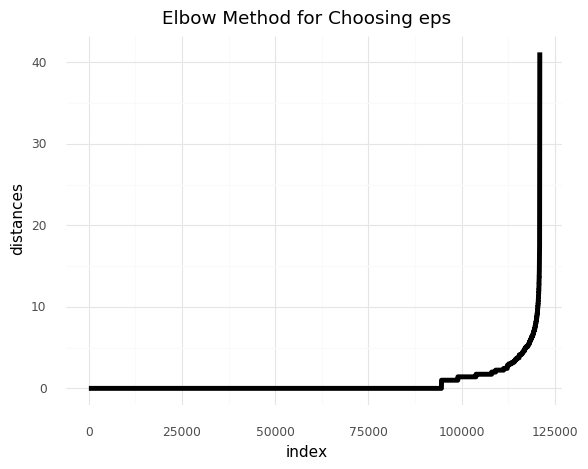

<ggplot: (8765118383011)>

In [18]:
#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
plt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "black", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps"))

plt

In [19]:
### YOUR CODE HERE ################################

# build your DBSCAN model with min_samples = 10, and eps = whatever you found
db_john = DBSCAN(eps = 4, min_samples = mins)

# fit your model with mount_df's RGB columns
db_john.fit(john_df[["R", "G", "B"]])

### /YOUR CODE HERE ###############################


DBSCAN(algorithm='auto', eps=4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

 ### Run these Cells after Running DBSCAN to see how the image colors were simplified


In [20]:
# grab the cluster assignment for each data point
cluster_db_john  = db_john.labels_

# grab the mean color for each cluster
centers_db_john = [list(john_df.loc[cluster_db_john == c,["R","G","B"]].mean()) for c in set(db_john.labels_)]
centers_db_john = np.round(centers_db_john) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers_db_john = [tuple(map(int, c)) for c in centers_db_john] 

In [21]:
# record which cluster each pixel is in
john_df["cluster_db"] = cluster_db_john 

# grab the cluster center (the NEW color) for that pixel
john_df["color_tuple_db"] = [centers_db_john [i] for i in john_df["cluster_db"]]

In [22]:
# Turn these new colors into an image so you can plot it
john_new_list = list(john_df["color_tuple_db"])
john_new = Image.new(john.mode,john.size)
john_new.putdata(john_new_list)

# show the NEW simpler image
john_new.show()

# show the original image
john.show()

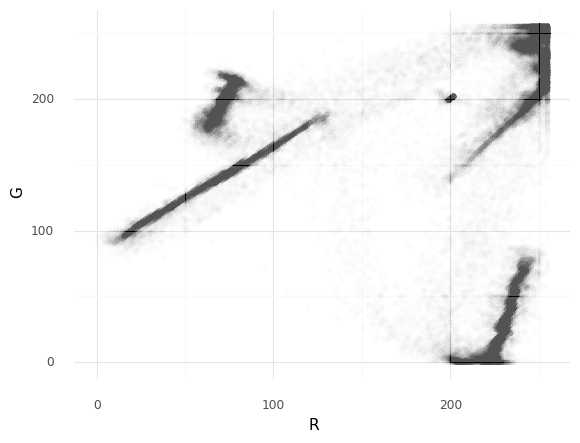

<ggplot: (8765120402011)>

In [23]:
(ggplot(john_df, aes(x = "R", y = "G")) + geom_point(alpha = 0.01) +
theme_minimal())

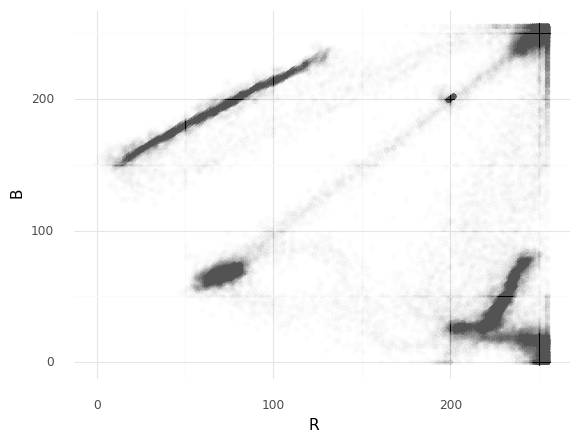

<ggplot: (8765179275867)>

In [24]:
(ggplot(john_df, aes(x = "R", y = "B")) + geom_point(alpha = 0.01) +
theme_minimal())

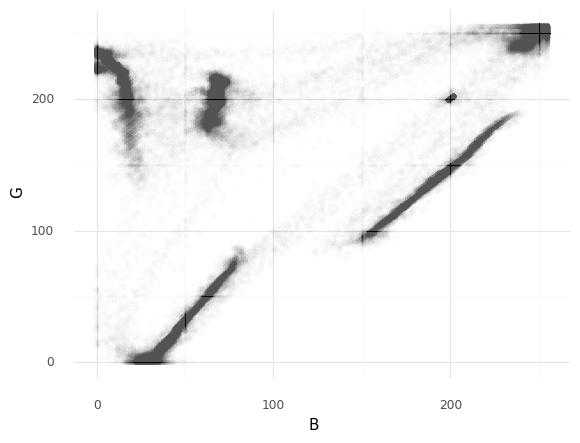

<ggplot: (8765179278511)>

In [25]:
(ggplot(john_df, aes(x = "B", y = "G")) + geom_point(alpha = 0.01) +
theme_minimal())

### Question
- Look at the shapes, spread, and patterns in the data. Why do you see that's interesting? What do the patterns tell you about why DBSCAN performed the way it did (remember the benefits/disadvantages of DBSCAN we discussed in the lecture)?

- Based on what you know about DBSCAN, why do you think it worked *better* in this image, than in the image of mountains?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>
